# Parallelize Python code with Dask Delayed

You can run the code in this notebook with the crt-003 conda environment.

Just run `conda env create -f envs/crt-003.yml` to install this environment.

## General Python code

In [1]:
from time import sleep

In [2]:
def inc(x):
    sleep(1)
    return x + 1

def dec(x):
    sleep(1)
    return x - 1

def add(x, y):
    sleep(1)
    return x + y

In [3]:
%%time

a = inc(1)
b = dec(1)
c = add(a, b)

CPU times: user 2.07 ms, sys: 2.16 ms, total: 4.23 ms
Wall time: 3 s


In [4]:
%%time

l = []

for i in range(10):
    a = inc(i)
    b = dec(i)
    c = add(a, b)
    l.append(c)

CPU times: user 3.37 ms, sys: 2.03 ms, total: 5.39 ms
Wall time: 30.1 s


## Dask Delayed

In [5]:
from dask.distributed import Client, progress
client = Client(n_workers=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 8,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50528,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:50533,Total threads: 8
Dashboard: http://127.0.0.1:50534/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:50531,


Open the dashboards!

In [6]:
from dask import delayed, compute, visualize

In [7]:
%%time

l = []

for i in range(10):
    a = delayed(inc)(i)
    b = delayed(dec)(i)
    c = delayed(add)(a, b)
    l.append(c)

CPU times: user 4.81 ms, sys: 1.85 ms, total: 6.66 ms
Wall time: 5.74 ms


**Note:** Don't do `delayed(inc(i))`

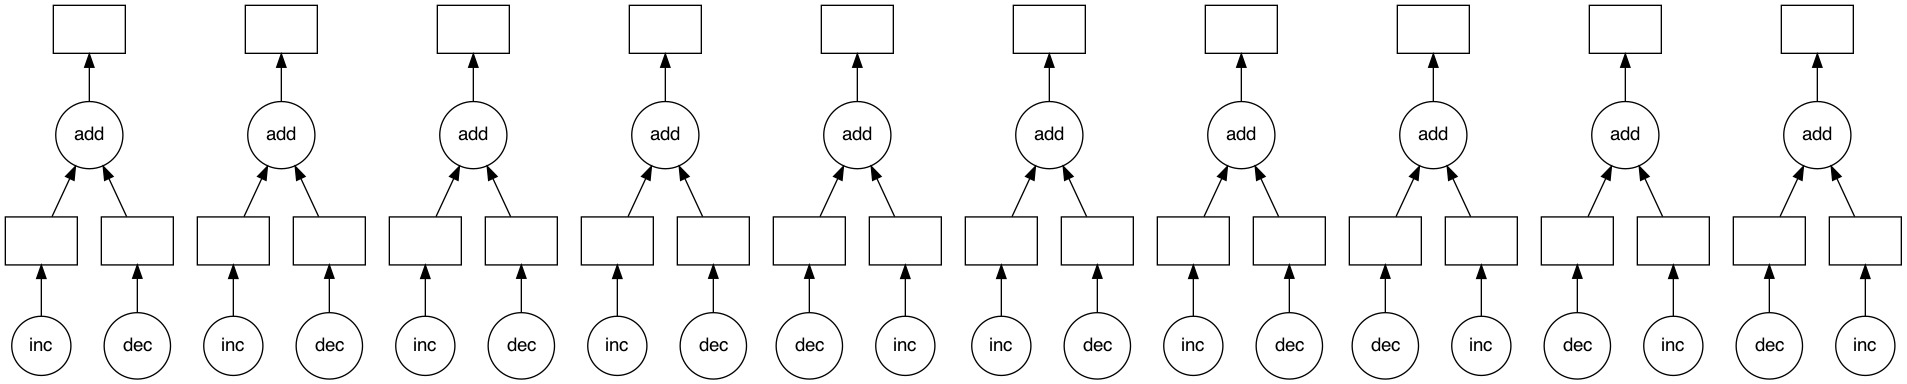

In [8]:
visualize(*l)

**Note:** Try to minimize computing.

In [9]:
%%time

l = compute(*l)
l

CPU times: user 290 ms, sys: 107 ms, total: 397 ms
Wall time: 4.25 s


(0, 2, 4, 6, 8, 10, 12, 14, 16, 18)

### Alternatively...

In [10]:
@delayed
def inc(x):
    sleep(1)
    return x + 1

@delayed
def dec(x):
    sleep(1)
    return x - 1

@delayed
def add(x, y):
    sleep(1)
    return x + y

Or:

In [11]:
# inc = delayed(inc)
# dec = delayed(dec)
# add = delayed(add)

In [12]:
%%time

l = []

for i in range(10):
    a = inc(i)
    b = dec(i)
    c = add(a, b)
    l.append(c)
    
l = compute(*l)

CPU times: user 184 ms, sys: 48.1 ms, total: 232 ms
Wall time: 4.1 s


## Another example: pandas

In [13]:
# !wget https://coiled-datasets.s3.us-east-2.amazonaws.com/seattle-library-checkouts/checkouts-subset.csv

In [14]:
import pandas as pd

In [15]:
%%time

ddf = delayed(pd.read_csv)("checkouts-subset.csv", 
                           engine='python', 
                           error_bad_lines=False) # with delayed

CPU times: user 279 µs, sys: 59 µs, total: 338 µs
Wall time: 331 µs


In [19]:
%%time

result = ddf.groupby("UsageClass").Checkouts.sum()

CPU times: user 499 µs, sys: 101 µs, total: 600 µs
Wall time: 606 µs


In [20]:
result

Delayed('sum-1449cdc7-26d3-4b72-bff4-9832af91f01c')

In [21]:
result.compute()

distributed.worker - WARNING - Compute Failed
Function:  execute_task
args:      ((<function apply at 0x10a2b4ee0>, <function read_csv at 0x167711670>, ['checkouts-subset.csv'], (<class 'dict'>, [['engine', 'python'], ['error_bad_lines', False]])))
kwargs:    {}
Exception: "FileNotFoundError(2, 'No such file or directory')"



FileNotFoundError: [Errno 2] No such file or directory: 'checkouts-subset.csv'

In [ ]:
client.close()

**Note:** Dask DataFrame is better for parallelizing pandas